# What Really Counts: A Cash Recognization System

---

**Group Members**:
- Ek Chin Hui (A0205578X)
- Lee Hyung Woon (A0218475X)
- Toh Hai Jie Joey (A0205141Y)

---

Our project, named **What Really Counts**, is a Cash Recognization System for the Visually Impaired in Singapore. In Singapore, the disabled community face many challenges in their daily lives, and this is especially so for those who are hampered by visual impairments. One such challenge they face is cash payment, as they need to identify the correct combinations of bills and coins. Hence, our aim was to contruct a system that can help them overcome these challenges by employing a deep learning-based Object Detection model using Convolutional Neural Networks (CNN) - in particular, the Faster R-CNN model. 

**What Really Counts** is an architecture that detects and analyzes given images of Singapore Currencies (bills and/or coins), and is primarily designed to assist the visually impaired in identifying the correct combinations of bills and coins. The model uses CNNs to perform image classification on the objects detected in a given input image, through which we can ascertain the exact number and type of bills / coins present in the image, allowing us to calculate and return the sum of the currency to the user.

For this project, we will gather and pre-process our own dataset, and then move onto training and testing of our model.

## Libraries

The following are modules that we used for this project...

In [27]:
import torch
import torch.nn.functional as F
import os
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT
import json
import time
import utils
import numpy as np
import numpy.random as npr

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import nms, RoIAlign
from PIL import Image
from glob import glob
from pathlib import Path

## Data Collection

For this project, we collected data by taking about 150 pictures of different combinations of bills and coins.

As an initial proof of concept, we decided to focus on the 7 most common classes of currencies in Singapore: \\$10, \\$5, \\$2, \\$1, 50c, 20c, 10c.

After we gathered the data, we manually labelled the bounding boxes and their respective classes using [LabelImg](https://github.com/tzutalin/labelImg), which produces an XML file for each image to store the bounding box and class information.

In [28]:
# Set class labels

coin_labels = ('10c', '20c', '50c', '$1', '$2', '$5', '$10')

label_index_dict = {k:v+1 for v, k in enumerate(coin_labels)}
label_index_dict['background'] = 0
print(label_index_dict)

index_label_dict = {v+1:k for v, k in enumerate(coin_labels)}
index_label_dict[0] = 'background'
print(index_label_dict)

{'10c': 1, '20c': 2, '50c': 3, '$1': 4, '$2': 5, '$5': 6, '$10': 7, 'background': 0}
{1: '10c', 2: '20c', 3: '50c', 4: '$1', 5: '$2', 6: '$5', 7: '$10', 0: 'background'}


Next, we defined a function to parse the XML files into a Python dictionary:

In [29]:
def parse_annotation(annotation_path):
    '''
    Function to convert XML data of a single image into an object.
    The object contains the Bbox parameters and the corresponding label for each Bbox.
    '''

    # Parse the XML file into a tree structure
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    height = float(root.find('size').find('height').text)
    width = float(root.find('size').find('width').text)

    # Set initial lists
    boxes = list()
    labels = list()

    # Loop over each Bbox found in the XML file
    for object in root.iter('object'):

        # Convert Bbox co-ordinates
        bbox = object.find('bndbox')
        xmin = int(bbox.find('xmin').text) - 1
        ymin = int(bbox.find('ymin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymax = int(bbox.find('ymax').text) - 1
        boxes.append([xmin, ymin, xmax, ymax])

        # Convert Bbox Label
        label = object.find('name').text.lower().strip()
        if label not in label_index_dict:
            continue
        labels.append(label_index_dict[label])

    return {'boxes': boxes, 'labels': labels}

Then, we defined another function that makes use of the earlier `parse_annotation` function to convert the XML files into JSON objects.

Each bounding box is stored as [xmin, ymin, xmax, ymax].

In [30]:
def xml_to_json(*files):
    '''
    Function to convert image and XML data into two separate JSON objects.
    One object for images, and another object for Bbox co-ordinate values and labels.
    '''
    
    # Initialise lists
    images_list = [] 
    objects_list = []
    files = [file for sublist in files for file in sublist]
    
    # Set up two JSON files to be written
    images_file = open("TRAIN_images.json", 'w')
    objects_file = open("TRAIN_objects.json", 'w')
    
    # Iterate through each XML-Image pair
    for file in files:
    
        # Add each image file path into the images list
        file_path = os.path.splitext(file)[0]   
        images_list.append(file_path + ".jpg")
        
        # Add each XML object into the objects list
        xml_dict = parse_annotation(file)
        objects_list.append(xml_dict)
    
    # Write each list into the corresponding JSON files
    json.dump(images_list, images_file)
    json.dump(objects_list, objects_file)

Then, we convert our dataset from XML to JSON accordingly.

In [31]:
CH_FILES = glob(r'dataset/ch dataset/*.xml')
xml_to_json(CH_FILES)

# JY_FILES = glob(r'dataset/joey dataset/*.xml')
# HW_FILES = glob(r'dataset/hw dataset/*.xml')
# xml_to_json(CH_FILES, HW_FILES)
# xml_to_json(HW_FILES)

## Data Preparation

Before getting started with our network, we need to do the necessary data preparation and pre-processing...

The function `normalise_and_resize` was partially adapted from the [PyTorch Tutorial to Object Detection](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py).

First, we declare a function to resize and normalise the given images and the bounding boxes. By default, we set it to dimensions `(320, 320)`, which is the standard input size that we will use for our network...

In [32]:
def normalise_and_resize(image, boxes, labels, dims = (320, 320)):
    '''
    Adapted from: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Resize the input images and the bounding boxes, and apply Normalisations.
    
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :return: transformed image, transformed bounding box coordinates, transformed labels, transformed difficulties
    '''

    # Mean and Standard deviation used for the base VGG from torchvision
    # See: https://pytorch.org/docs/stable/torchvision/models.html
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Resize image and convert the image to Torch tensor
    new_image = FT.resize(image, dims)
    new_image = FT.to_tensor(new_image)
    
    # Normalize the image by mean and standard deviation
    new_image = FT.normalize(new_image, mean = mean, std = std)

    # Resize Bounding boxes
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
    new_boxes = (boxes / old_dims) * new_dims
    
    return new_image, new_boxes, labels

Next, we declare a class PascalVOCDataset (Dataset in Pascal VOC format) that we can use to create batches of data easily and efficiently...

In [33]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader.
    This class is primarily used to create batches.
    """
    
    def __init__(self, data_folder, split):
        '''
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        '''

        self.data_folder = data_folder
        self.split = split.upper()
        
        # The values of split should only be either 'TRAIN' or 'TEST'
        assert self.split in {'TRAIN', 'TEST'}

        # Read from the JSON files (initially craeted from our XML files)
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        # Number of images must match the number of objects containing the Bboxes for each image
        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        '''
        ...
        '''

        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')
        image_tensor = transforms.ToTensor()(image)
        image_tensor = transforms.Resize(size = (320, 320))(image_tensor)

        # Read objects in this image (Bboxes, labels)
        objects = self.objects[i]
        box = torch.FloatTensor(objects['boxes'])
        label = torch.LongTensor(objects['labels'])

        # Apply normalisations and resizes
        image, box, label = normalise_and_resize(image, box, label)
        box_and_label = torch.cat([box, label.unsqueeze(1)], 1)
        return image_tensor, box_and_label

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        '''
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes using Python lists.
        
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        '''

        images = list()
        boxes = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])

        images = torch.stack(images, dim = 0)
        return images, boxes

Finally, we load our training and test dataset using PyTorch's DataLoader, which allows us to iterate through the dataset easily. The original dataset was randomly split into the train and test set, with a ratio of 80:20. 

Additionally, since our dataset was relatively small, we chose to stick to a batch size of 1 to achieve better training stability and generalization performance.

In [34]:
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
import math

def display_img_bbox(img, gt_bboxes, predictions=()):
    plt.imshow(transforms.ToPILImage()(img))
    gt_bbox_color = 'g'
    pred_color = 'r'
    fs = 10
    # ax = plt.gca()
    # labelled = set()

    # plot gt_boxes
    for bbox in gt_bboxes:
        w,h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        x,y = bbox[0], bbox[1]
        x = [x, x + w, x + w, x, x]
        y = [y, y, y + h, y + h, y]
        label_idx = bbox[4].item()
        label = index_label_dict[label_idx]
        plt.text(x[0], y[0], label, fontsize=fs)
        plt.plot(x,y, color = gt_bbox_color, label = label)
    
    # plot predicted boxes
    for bbox in predictions:
        w,h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        x,y = bbox[0], bbox[1]
        x = [x, x + w, x + w, x, x]
        y = [y, y, y + h, y + h, y]
        label = index_label_dict[bbox[4]]
        plt.text(x[0], y[0], label, fontsize=fs)
        plt.plot(x,y, color = pred_color, label = label)
    

In [35]:
dataset = PascalVOCDataset(".", "TRAIN")
length = len(dataset)
train_data, test_data = torch.utils.data.random_split(dataset, [math.floor(0.8*length), math.ceil(0.2*length)])
train_dataloader = DataLoader(train_data, batch_size = 1, shuffle = True, collate_fn = dataset.collate_fn)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle = True, collate_fn = dataset.collate_fn)

## Data Visualisation

To ensure that our Data Preparations are complete, we may use the `matplotlib` library to visualise our dataset.

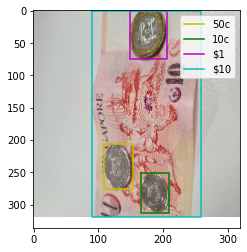

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math

color_maps = ['r', 'g', 'b', 'y', 'm', 'w', 'k', 'c']

# Visualise data
for data in train_dataloader:
    for batch in range(1):
        img = data[0][batch]
        boxes = data[1][batch]
#         labels = data[2][batch].tolist()
#         named_labels = [index_label_dict[label] for label in labels]
        plt.imshow(transforms.ToPILImage()(img))
        ax = plt.gca()
        labelled = set()
        for i, box in enumerate(boxes):
            w,h = box[2] - box[0], box[3] - box[1]
            x,y = box[0].item(), box[1].item()
            x = [x, x + w, x + w, x, x]
            y = [y, y, y + h, y + h, y]
            label = int(box[4].item())
            if label not in labelled:
                plt.plot(x,y, color = color_maps[label], label = index_label_dict[label])
                labelled.add(label)
            else:
                plt.plot(x,y, color = color_maps[label])
            plt.legend(loc = 'best')
        break
    break

# Constructing the Model 

In order to simplify our model, we first declared a few utility functions.

Firstly, we declare functions that will help us generate the anchors for our network. To do so efficiently, we need functions to help us switch the data format of the images (and the bounding boxes) from the Pascal VOC format to the YOLO format:

In [37]:
def pascal2yolo(anchor):
    '''
    Transforms anchor coordinates of the form [xmin, ymin, xmax, ymax] to [x_center, y_center, width, height]
    '''
    
    width = anchor[2] - anchor[0] + 1
    height = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + (width-1)/2 
    y_ctr = anchor[1] + (height-1)/2
    return width, height, x_ctr, y_ctr

def yolo2pascal(width, height, x_ctr, y_ctr):
    '''
    Transforms anchor coordinates of the form [x_center, y_center, width, height] to [xmin, ymin, xmax, ymax]
    '''
    
    width = width[:, np.newaxis]
    height = height[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (width - 1), y_ctr - 0.5 * (height - 1),
                         x_ctr + 0.5 * (width - 1), y_ctr + 0.5 * (height - 1)))
    return anchors

Next, we declare utility functions for generating the anchors themselves:

In [38]:
def generate_ratio_anchors(anchor, ratios=(0.5,1,2)):
    '''
    Generate anchors for each width:height ratio
    '''
    
    w,h,x_ctr,y_ctr = pascal2yolo(anchor)
    size = w*h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = yolo2pascal(ws, hs, x_ctr, y_ctr)
    return anchors

def generate_scale_anchors(anchor, scales=np.array((8,16,32))):
    '''
    Generate anchors for each scale
    '''
    
    w,h,x_ctr,y_ctr = pascal2yolo(anchor) 
    scaled_w = w * scales
    scaled_h = h * scales
    anchors = yolo2pascal(scaled_w, scaled_h, x_ctr, y_ctr)
    return anchors

def generate_anchors(height, width, aspect_ratio=np.array((0.5,1,2)), stride_length=16, scales=np.array((8,16,32))):
    '''
    Generate anchors of differing scale and aspect ratios
    '''
    
    base_anchor = pascal2yolo([0,0,15,15]) # 16, 16, 7.5, 7.5
    ratio_anchors = generate_ratio_anchors(base_anchor, ratios=aspect_ratio)
    anchors = np.vstack([
        generate_scale_anchors(ratio_anchors[i, :], scales)
        for i in range(ratio_anchors.shape[0])
    ])
    A = anchors.shape[0]
    shift_x = np.arange(0, width) * stride_length
    shift_y = np.arange(0, height) * stride_length
    
    # Shift each ratio
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(),
                        shift_y.ravel())).transpose()
    K = shifts.shape[0]
    anchors = anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)) # H, W, C
    anchors = anchors.reshape((K * A, 4)).astype(np.float32, copy=False)
    length = np.int32(anchors.shape[0])

    return anchors, length

Next, we declare a couple of utility functions to help us manipulate and deal with bounding boxes.

BBox transformations using deltas & inverse ...

Clip bboxes to image boundaries...

Calculate bbox overlaps...

In [39]:
def bbox_transform(ex_rois, gt_rois):
    '''
    ...
    '''
    
    ex_rois = ex_rois.to(device)
    gt_rois = gt_rois.to(device)
    
    ex_widths = ex_rois[:, 2] - ex_rois[:, 0] + 1.0
    ex_heights = ex_rois[:, 3] - ex_rois[:, 1] + 1.0
    ex_ctr_x = ex_rois[:, 0] + 0.5 * ex_widths
    ex_ctr_y = ex_rois[:, 1] + 0.5 * ex_heights

    gt_widths = gt_rois[:, 2] - gt_rois[:, 0] + 1.0
    gt_heights = gt_rois[:, 3] - gt_rois[:, 1] + 1.0
    gt_ctr_x = gt_rois[:, 0] + 0.5 * gt_widths
    gt_ctr_y = gt_rois[:, 1] + 0.5 * gt_heights

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = torch.log(gt_widths / ex_widths)
    targets_dh = torch.log(gt_heights / ex_heights)

    targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh), 1)
    return targets.cpu()

def bbox_transform_inv(boxes, deltas):
    '''
    ...
    '''

    if len(boxes) == 0:
        return deltas.detach() * 0
    boxes = boxes.to(device)
    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights
    dx = deltas[:, 0::4]
    dy = deltas[:, 1::4]
    dw = deltas[:, 2::4]
    dh = deltas[:, 3::4]

    pred_ctr_x = dx * widths.unsqueeze(1) + ctr_x.unsqueeze(1)
    pred_ctr_y = dy * heights.unsqueeze(1) + ctr_y.unsqueeze(1)
    pred_w = torch.exp(dw) * widths.unsqueeze(1)
    pred_h = torch.exp(dh) * heights.unsqueeze(1)

    pred_boxes = torch.cat([_.unsqueeze(2) for _ in [pred_ctr_x - 0.5 * pred_w,
        pred_ctr_y - 0.5 * pred_h,
        pred_ctr_x + 0.5 * pred_w,
        pred_ctr_y + 0.5 * pred_h]], 2).view(len(boxes), -1)
    return pred_boxes

def clip_boxes(boxes, im_shape):
    '''
    Clip boxes to image boundaries
    '''

    if not hasattr(boxes, 'data'):
        boxes_ = boxes.numpy()

    boxes = boxes.view(boxes.size(0), -1, 4)
    boxes = torch.stack([boxes[:,:,0].clamp(0, im_shape[1] - 1),
        boxes[:,:,1].clamp(0, im_shape[0] - 1),
        boxes[:,:,2].clamp(0, im_shape[1] - 1),
        boxes[:,:,3].clamp(0, im_shape[0] - 1)], 2).view(boxes.size(0), -1)
    return boxes

def bbox_overlaps(boxes, query_boxes):
    '''
    Computes the overlapped area between boxes and query boxes (ground truth boxes)
    using intersection-over-union
    
    Parameters
    ----------
    boxes: (N, 4) ndarray or tensor or variable
    query_boxes: (K, 4) ndarray or tensor or variable
    Returns
    -------
    overlaps: (N, K) overlap between boxes and query_boxes
    '''
    
    # If input is ndarray, turn the overlaps back to ndarray when return
    if isinstance(boxes, np.ndarray):
        boxes = torch.from_numpy(boxes)
        query_boxes = torch.from_numpy(query_boxes)
        out_fn = lambda x: x.numpy()  
    else:
        out_fn = lambda x: x

    boxes = boxes.to(device)
    query_boxes = query_boxes.to(device)
    box_areas = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    query_areas = (query_boxes[:, 2] - query_boxes[:, 0] + 1) * (query_boxes[:, 3] - query_boxes[:, 1] + 1)

    iw = (torch.min(boxes[:, 2:3], query_boxes[:, 2:3].t()) - torch.max(boxes[:, 0:1], query_boxes[:, 0:1].t()) + 1).clamp(min=0)
    ih = (torch.min(boxes[:, 3:4], query_boxes[:, 3:4].t()) - torch.max(boxes[:, 1:2], query_boxes[:, 1:2].t()) + 1).clamp(min=0)
    ua = box_areas.view(-1, 1) + query_areas.view(1, -1) - iw * ih
    overlaps = iw * ih / ua
    return out_fn(overlaps.cpu())

Unmap function for the anchor target layer...

In [40]:
def unmap(data, count, inds, fill=0):
    '''
    Unmap a subset of item (data) back to the original set of items (of size count)
    '''
    
    if len(data.shape) == 1:
        ret = np.empty((count, ), dtype=np.float32)
        ret.fill(fill)
        ret[inds] = data
    else:
        ret = np.empty((count, ) + data.shape[1:], dtype=np.float32)
        ret.fill(fill)
        ret[inds, :] = data
    return ret

...

In [41]:
BBOX_NORMALIZE_MEANS = (0.0, 0.0, 0.0, 0.0)
BBOX_NORMALIZE_STDS = (0.1, 0.1, 0.2, 0.2)
BBOX_INSIDE_WEIGHTS = (1.0, 1.0, 1.0, 1.0)

def get_bbox_regression_labels(bbox_target_data, num_classes):
    '''
    Bounding-box regression targets (bbox_target_data) are stored in a
    compact form N x (class, tx, ty, tw, th)
    This function expands those targets into the 4-of-4*K representation used
    by the network (i.e. only one class has non-zero targets).
    
    Returns:
        bbox_target (ndarray): N x 4K blob of regression targets
        bbox_inside_weights (ndarray): N x 4K blob of loss weights
    '''

    clss = bbox_target_data[:, 0]
    bbox_targets = clss.new_zeros(clss.numel(), 4 * num_classes)
    bbox_inside_weights = clss.new_zeros(bbox_targets.shape)
    inds = (clss > 0).nonzero().view(-1)
    if inds.numel() > 0:
        clss = clss[inds].contiguous().view(-1, 1)
        dim1_inds = inds.unsqueeze(1).expand(inds.size(0), 4)
        dim2_inds = torch.cat([4 * clss, 4 * clss + 1, 4 * clss + 2, 4 * clss + 3], 1).long()
        test = bbox_target_data[inds][:, 1:]
        bbox_targets[dim1_inds, dim2_inds] = test
        bbox_inside_weights[dim1_inds, dim2_inds] = bbox_targets.new(BBOX_INSIDE_WEIGHTS).view(-1, 4).expand_as(dim1_inds)

    return bbox_targets, bbox_inside_weights

...

In [42]:
def fix_sample_regions(fg_inds, bg_inds, gt_boxes, all_rois, rois_per_image):
    '''
    Function to ensure total number of foreground and background ROIs is constant
    by randomly repeating background indices to make up for lesser foreground indices.
    '''
    
    if fg_inds.numel() == 0 and bg_inds.numel() == 0:
        to_replace = all_rois.size(0) < rois_per_image
        bg_inds = torch.from_numpy(npr.choice(np.arange(0, all_rois.size(0)), size=int(rois_per_image), replace=to_replace)).long()
        fg_rois_per_image = 0
    elif fg_inds.numel() > 0 and bg_inds.numel() > 0:
        fg_rois_per_image = min(fg_rois_per_image, fg_inds.numel())
        fg_inds = fg_inds[torch.from_numpy(
            npr.choice(
                np.arange(0, fg_inds.numel()),
                size=int(fg_rois_per_image),
                replace=False)).long().to(gt_boxes.device)]
        bg_rois_per_image = rois_per_image - fg_rois_per_image
        to_replace = bg_inds.numel() < bg_rois_per_image
        bg_inds = bg_inds[torch.from_numpy(
            npr.choice(
                np.arange(0, bg_inds.numel()),
                size=int(bg_rois_per_image),
                replace=to_replace)).long().to(gt_boxes.device)]
    elif fg_inds.numel() > 0:
        to_replace = fg_inds.numel() < rois_per_image
        fg_inds = fg_inds[torch.from_numpy(
            npr.choice(
                np.arange(0, fg_inds.numel()),
                size=int(rois_per_image),
                replace=to_replace)).long().to(gt_boxes.device)]
        fg_rois_per_image = rois_per_image
    elif bg_inds.numel() > 0:
        to_replace = bg_inds.numel() < rois_per_image
        bg_inds = bg_inds[torch.from_numpy(
            npr.choice(
                np.arange(0, bg_inds.numel()),
                size=int(rois_per_image),
                replace=to_replace)).long().to(gt_boxes.device)]
        fg_rois_per_image = 0

    return fg_inds, bg_inds, gt_boxes, all_rois, rois_per_image

# Faster R-CNN Model

First, we set the network constants as follows:

In [43]:
# Set network constants
HIDDEN_DIM = 64
NUM_OF_CLASS = 8
BATCH_SIZE = 1

# Thresholds
# Overlap threshold for a ROI to be considered foreground (if >= FG_THRESH)
# Overlap threshold for a ROI to be considered background (class = 0 if overlap in [LO, HI))
FG_THRESH = 0.5 
BG_THRESH_HI = 0.5
BG_THRESH_LO = 0.1

PRE_NMS_TOPN = 12000
POST_NMS_TOPN = 2000
NMS_THRESH = 0.7

POSITIVE_OVERLAP = 0.7
NEGATIVE_OVERLAP = 0.3
CLOBBER_POSITIVES = False
RPN_BATCH_SIZE = 8
FG_FRACTION = 0.5
RPN_POSITIVE_WEIGHT = -1.0
POOLING_SIZE = 7
BBOX_INSIDE_WEIGHTS = ()

The flow of our faster RCNN model is as follows:
### 1. Head Network
The head network consists of 4 convolutional layers with max pooling and RELU activation between each layer. It serves as the "backbone" network and its purpose is to produce convolutional feature maps to be used in anchor generation and region proposal network.
### 2. Anchor Generation Layer
The anchor generation layer generates a fixed number of anchors. We first generated 9 anchors of differing scales (8, 16, 32) and aspect ratios (0.5, 1, 2) and then duplicated these anchors by translating them across uniformly spaced grid points spanning the input image.
### 3. Region Proposal Network (RPN)
The region proposal layer runs feature maps produced by the head network through a convolutional layer followed by RELU. Its purpose is to produce the background/foreground class scores and probabilities, and corresponding bounding box regression coefficients.
### 4. Proposal Layer
The proposal layer prunes the number of boxes and transforms the bounding boxes. The pruning is done by applying non-maximum suppression based on the foreground scores, while the transformation is done by applying the regression coefficients generated by the RPN to the corresponding anchor boxes. The purpose of this layer is to produce ROIs.
### 5. Anchor Target Layer
The anchor target layer selects promising anchors from the anchors generated by first computing the overlap between the anchors and the ground truth boxes. The anchors will then be selected based on certain overlap thresholds. These anchors will then be used to train the RPN. 
### 6. Proposal Target Layer
The proposal target layer selects promising ROIs that are generated by first computing the max overlap between each ROI and all ground truth boxes. The ROIs will then be selected based on certain overlap thresholds.
### 7. ROI Pooling Layer
The ROI pooling layer crops the features produced by the head network using the ROI Align method (interpolation).
### 8. Region Classification Network (RCNN)
The region classification layer passes the feature maps produced by the head network through a single convolutional layer and two fully connected (FC) layers. The first FC layer produces the class probability distribution for each region proposal and the second FC layer produces a set of class specific bounding box regressors.
### 9. Computing Loss
The total loss is the sum of the classification loss and bounding box regression loss in both the RPN and RCNN. The classification loss uses cross entropy loss to penalize incorrectly classified boxes while the regression loss uses a function of the distance between the true regression coefficients.

In [44]:
class faster_R_CNN(nn.Module):
    """
    The main Faster R-CNN network used for this project.
    """
    
    def __init__(self):
        super(faster_R_CNN, self).__init__()
        self.feat_stride = [16,]
        self._predictions = {}
        self._losses = {}
        self._anchor_targets = {}
        self._proposal_targets = {}
        self._layers = {}
        self._act_summaries = {}
        self._score_summaries = {}
        self._event_summaries = {}
        self._image_gt_summaries = {}
        self._variables_to_fix = {}
        self._fc_channels = RPN_BATCH_SIZE*RPN_BATCH_SIZE*25
        self._net_conv_channels = 1024

        # This results in num_anchors = 9
        anchor_scales = (8, 16, 32)
        anchor_ratios = (0.5, 1, 2)
        self.n_anchors = len(anchor_scales) * len(anchor_ratios)  
        
        # HeadNet: Generating a series of Feature maps from the input image
        
        # Current Size: 3 x h x w
        self.head_conv1 = nn.Conv2d(3,  HIDDEN_DIM,  kernel_size=4, stride=2, padding=1)
        # Current Size: 64 x h/2 x w/2
        self.head_batch_norm1 = nn.BatchNorm2d(HIDDEN_DIM)
        # Current Size: 64 x h/2 x w/2 
        self.head_relu1 = nn.ReLU()
        # Current Size: 64 x h/2 x w/2
        self.head_pool1 = nn.MaxPool2d([3,3], padding=1, stride=2)
        # Current Size: 64 x h/4 x w/4
        self.head_layer1 = nn.Conv2d(HIDDEN_DIM,  HIDDEN_DIM*4,  kernel_size=3, padding=1)
        self.head_relu2 = nn.ReLU()
        # Current Size: 256 x h/4 x w/4
        self.head_layer2 = nn.Conv2d(HIDDEN_DIM*4,  HIDDEN_DIM*8,  kernel_size=3, padding=1)
        self.head_pool2 = nn.MaxPool2d([3,3], padding=1, stride=2)
        self.head_relu3 = nn.ReLU()
        # Current Size: 512 x h/8 x w/8
        self.head_layer3 = nn.Conv2d(HIDDEN_DIM*8,  HIDDEN_DIM*16,  kernel_size=3, padding=1)
        self.head_pool3 = nn.MaxPool2d([3,3], padding=1, stride=2)
        self.head_relu4 = nn.ReLU()
        # Current Size: 1024 x h/16 x w/16
        
        # Region Proposal Network
        self.rpn_net = nn.Conv2d(self._net_conv_channels, 512 , kernel_size=3, padding=1)
        self.rpn_cls_score_net = nn.Conv2d(512, self.n_anchors*2, [1,1])
        self.rpn_bbox_pred_net = nn.Conv2d(512, self.n_anchors*4, [1,1])

        # Classification Network
        # [256, 256, 5, 5]
        self.cls_score_net = nn.Linear(self._fc_channels, RPN_BATCH_SIZE*NUM_OF_CLASS)     
        self.bbox_pred_net = nn.Linear(self._fc_channels, RPN_BATCH_SIZE*NUM_OF_CLASS*4)

    def head_net(self):
        return nn.Sequential(
            self.head_conv1,
            self.head_batch_norm1,
            self.head_relu1,
            self.head_pool1,
            self.head_layer1,
            self.head_relu2,
            self.head_layer2,
            self.head_pool2,
            self.head_relu3,
            self.head_layer3,
            self.head_pool3,
            self.head_relu4
        )

    def fc7(self):
        return nn.Sequential(
            # Current Size: n x 1024 x 7 x 7
            # nn.Conv2d(self._predictions["rois"].size(0), self._predictions["rois"].size(0),  kernel_size=3, padding=1),
            nn.Conv2d(1024, self._predictions["rois"].size(0),  kernel_size=3, padding=1),
            nn.AvgPool2d([3,3], 1)
            # Current Size: n x 4096 x 3 x 3
        ) # 256
        

    def proposal_layer(self, cls_prob, bbox_pred, anchors, n_anchors):
        '''
        Prunes no. of boxes using NMS based on fg scores and transforms bbox using regression coeff
        bbox_pred: BATCH_SIZE * h * w * (num_anchors*4)  
        '''
        
        # Get the scores and bounding boxes
        scores = cls_prob[:, :, :, n_anchors:]
        rpn_bbox_pred = bbox_pred.view((-1, 4))
        scores = scores.contiguous().view(-1, 1)
        proposals = bbox_transform_inv(anchors, rpn_bbox_pred) # shift boxes based on prediction
        proposals = clip_boxes(proposals, self._im_info[:2])

        # NMS Selection
        
        # Pick the top region proposals
        scores, order = scores.view(-1).sort(descending=True)
        if PRE_NMS_TOPN > 0:
            order = order[:PRE_NMS_TOPN]
            scores = scores[:PRE_NMS_TOPN].view(-1, 1)
        proposals = proposals[order.data, :]

        # Non-maximal suppression
        keep = nms(proposals, scores.squeeze(1), NMS_THRESH)

        # Pick the top region proposals after NMS
        if POST_NMS_TOPN > 0:
            keep = keep[:POST_NMS_TOPN]
        proposals = proposals[keep, :]
        scores = scores[keep, ]

        # Only support single image as input
        batch_inds = proposals.new_zeros(proposals.size(0), 1)
        blob = torch.cat((batch_inds, proposals), 1)
        
        return blob, scores

    def anchor_target_layer(self, rpn_cls_score, gt_boxes, all_anchors, im_info=[320, 320, 1]):
        '''
        ### Parameters ###
        rpn_cls_score: Class scores generated by the Region Proposal Network
        gt_boxes: Ground Truth boxes
        all_anchors: Anchor boxes generated by the anchor generation layer
        
        ### Fixed Parameters ###
        im_info: Image dimensions
        num_anchors: Number of different Anchor boxes used. By default, it is set to 9 here.

        ### Additional information ###
        POSITIVE_OVERLAP:       Threshold used to select if an anchor box is a good foreground box (Default: 0.7)

        NEGATIVE_OVERLAP:       If the max overlap of a anchor from a ground truth box is lower than this thershold, it is marked as background. 
                                Boxes whose overlap is > than NEGATIVE_OVERLAP but < POSITIVE_OVERLAP are marked 
                                “don’t care”. (Default: 0.3)
        
        CLOBBER_POSITIVES:      If a particular anchor is satisfied by both the positive and the negative conditions,
                                and if this value is set to False, then set the anchor to a negative example.
                                Else, set the anchor to a positive example.
        
        RPN_BATCH_SIZE:                 Total number of background and foreground anchors. (Default: 256)
        
        FG_FRACTION:            Fraction of the batch size that is foreground anchors (Default: 0.5). 
                                If the number of foreground anchors found is larger than RPN_BATCH_SIZE * FG_FRACTION, 
                                the excess (indices are selected randomly) is marked “don’t care”.
                            
        RPN_POSITIVE_WEIGHT:    Using this value:
                                Positive RPN examples are given a weight of RPN_POSITIVE_WEIGHT * 1 / num_of_positives
                                Negative RPN examples are given a weight of (1 - RPN_POSITIVE_WEIGHT)
                                Set to -1 by default, which will ensure uniform example weighting.
        '''

        # Map of shape (..., H, W)
        height, width = rpn_cls_score.shape[1:3]

        # Only keep anchors that are completely inside the image
        inds_inside = np.where(
            (all_anchors[:, 0] >= 0) &
            (all_anchors[:, 1] >= 0) &
            (all_anchors[:, 2] < im_info[1]) &  # width
            (all_anchors[:, 3] < im_info[0])  # height
        )[0]
        anchors = all_anchors[inds_inside, :]

        # Label: 1 is positive, 0 is negative, -1 is dont care
        labels = np.empty((len(inds_inside), ), dtype=np.float32)
        labels.fill(-1)

        # BUG: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor
        gt_boxes = torch.stack(gt_boxes).squeeze()
        # Overlaps between the Anchors and the Ground Truth boxes
        overlaps = bbox_overlaps(
            np.ascontiguousarray(anchors, dtype=np.float),
            np.ascontiguousarray(gt_boxes, dtype=np.float))
        argmax_overlaps = overlaps.argmax(axis=1)
        max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]
        gt_argmax_overlaps = overlaps.argmax(axis=0)
        gt_max_overlaps = overlaps[gt_argmax_overlaps, np.arange(overlaps.shape[1])]
        gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]

        # Set anchors whose overlap < NEGATIVE_OVERLAP to a negative example
        # "Positives clobber Negatives"
        if not CLOBBER_POSITIVES:
            labels[max_overlaps < NEGATIVE_OVERLAP] = 0

        # Foreground label: for each Ground Truth box, anchor with highest overlap
        labels[gt_argmax_overlaps] = 1

        # Foreground label: above threshold IOU
        labels[max_overlaps >= POSITIVE_OVERLAP] = 1

        # Set anchors whose overlap < NEGATIVE_OVERLAP to a negative example
        # "Negatives clobber Positives"
        if CLOBBER_POSITIVES:
            labels[max_overlaps < NEGATIVE_OVERLAP] = 0

        # Subsample positive labels if we have too many
        num_fg = int(FG_FRACTION * RPN_BATCH_SIZE)
        fg_inds = np.where(labels == 1)[0]
        if len(fg_inds) > num_fg:
            disable_inds = npr.choice(fg_inds, size=(len(fg_inds) - num_fg), replace=False)
            labels[disable_inds] = -1

        # Subsample negative labels if we have too many
        num_bg = RPN_BATCH_SIZE - np.sum(labels == 1)
        bg_inds = np.where(labels == 0)[0]
        if len(bg_inds) > num_bg:
            disable_inds = npr.choice(bg_inds, size=(len(bg_inds) - num_bg), replace=False)
            labels[disable_inds] = -1

        bbox_targets = np.zeros((len(inds_inside), 4), dtype=np.float32)
        labels = torch.from_numpy(labels)
                
        gt_rois_np = gt_boxes[argmax_overlaps, :].numpy()
        bbox_targets = bbox_transform(anchors, torch.from_numpy(gt_rois_np[:, :4])).numpy()
        
        bbox_inside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
        # Only the positive ones have regression targets
        bbox_inside_weights[labels == 1, :] = np.array((1.0, 1.0, 1.0, 1.0))

        labels = labels.numpy()
        bbox_outside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
        if RPN_POSITIVE_WEIGHT < 0:
            # Uniform weighting of examples (given non-uniform sampling)
            num_examples = np.sum(labels >= 0)
            positive_weights = np.ones((1, 4)) * 1.0 / num_examples
            negative_weights = np.ones((1, 4)) * 1.0 / num_examples
        else:
            assert ((RPN_POSITIVE_WEIGHT > 0) &
                    (RPN_POSITIVE_WEIGHT < 1))
            positive_weights = (
                RPN_POSITIVE_WEIGHT / np.sum(labels == 1))
            negative_weights = (
                (1.0 - RPN_POSITIVE_WEIGHT) / np.sum(labels == 0))
        bbox_outside_weights[labels == 1, :] = positive_weights
        bbox_outside_weights[labels == 0, :] = negative_weights

        # Map up to original set of anchors
        total_anchors = all_anchors.shape[0]
        labels = unmap(labels, total_anchors, inds_inside, fill=-1)

        bbox_targets = unmap(bbox_targets, total_anchors, inds_inside, fill=0)
        bbox_inside_weights = unmap(bbox_inside_weights, total_anchors, inds_inside, fill=0)
        bbox_outside_weights = unmap(bbox_outside_weights, total_anchors, inds_inside, fill=0)

        # Labels
        labels = labels.reshape((1, height, width, self.n_anchors)).transpose(0, 3, 1, 2)
        labels = labels.reshape((1, 1, self.n_anchors * height, width))
        rpn_labels = labels
        
        # Bounding boxes
        bbox_targets = bbox_targets.reshape((1, height, width, self.n_anchors * 4))
        rpn_bbox_targets = bbox_targets
        bbox_inside_weights = bbox_inside_weights.reshape((1, height, width, self.n_anchors * 4))
        rpn_bbox_inside_weights = bbox_inside_weights
        bbox_outside_weights = bbox_outside_weights.reshape((1, height, width, self.n_anchors * 4))
        rpn_bbox_outside_weights = bbox_outside_weights

        # Re-shape for future use
        rpn_labels = torch.from_numpy(rpn_labels).float() #.set_shape([1, 1, None, None])
        rpn_bbox_targets = torch.from_numpy(rpn_bbox_targets).float() #.set_shape([1, None, None, self._num_anchors * 4])
        rpn_bbox_inside_weights = torch.from_numpy(rpn_bbox_inside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
        rpn_bbox_outside_weights = torch.from_numpy(rpn_bbox_outside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
        rpn_labels = rpn_labels.long()

        # Data storing
        self._anchor_targets['rpn_labels'] = rpn_labels
        self._anchor_targets['rpn_bbox_targets'] = rpn_bbox_targets
        self._anchor_targets['rpn_bbox_inside_weights'] = rpn_bbox_inside_weights
        self._anchor_targets['rpn_bbox_outside_weights'] = rpn_bbox_outside_weights

        for k in self._anchor_targets.keys():
            self._score_summaries[k] = self._anchor_targets[k]

        return rpn_labels
        
    def proposal_target_layer(self, proposed_rois, proposed_roi_scores, gt_boxes):
        '''
        1. Calculate overlap between ROI and GT boxes
        2. Select promising ROIs by comparing against threshold(s)
        3. Compute bounding box target regression targets and get bounding box regression labels
        '''
        # Proposal ROIs (0, x1, y1, x2, y2) coming from RPN
        gt_boxes = torch.stack(gt_boxes).squeeze()
        # print("gt_boxes: ", gt_boxes)
        num_images = 1
        rois_per_image = RPN_BATCH_SIZE / num_images
        # print("rois per image", rois_per_image)
        fg_rois_per_image = int(round(FG_FRACTION * rois_per_image))

        # Sample rois with classification labels and bounding box regression targets
        # overlaps: (rois x gt_boxes)
        overlaps = bbox_overlaps(proposed_rois[:, 1:5].data, gt_boxes[:, :4].data)
        max_overlaps, gt_assignment = overlaps.max(1)
        labels = gt_boxes[gt_assignment, [4]]

        # Select foreground RoIs as those with >= FG_THRESH overlap
        fg_inds = (max_overlaps >= FG_THRESH).nonzero().view(-1)
        
        # Guard against the case when an image has fewer than fg_rois_per_image
        # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
        bg_inds = ((max_overlaps < BG_THRESH_HI) + (max_overlaps >= BG_THRESH_LO) == 2).nonzero().view(-1)

        # Ensure a fixed number of regions are sampled (optional?)
        fg_inds, bg_inds, gt_boxes, proposed_rois, rois_per_image = fix_sample_regions(fg_inds, bg_inds, gt_boxes, proposed_rois, rois_per_image)
        
        # The indices that we're selecting (both fg and bg)
        keep_inds = torch.cat([fg_inds, bg_inds], 0)

        # Select sampled values from various arrays:
        labels = labels[keep_inds].contiguous()

        # Clamp labels for the background RoIs to 0
        labels[int(fg_rois_per_image):] = 0
        rois_final = proposed_rois[keep_inds].contiguous()
        roi_scores_final = proposed_roi_scores[keep_inds].contiguous()
        
        # Compute bounding box target regression targets
        ex_rois = rois_final[:, 1:5].data
        gt_rois = gt_boxes[gt_assignment[keep_inds]][:, :4].data
        targets = bbox_transform(ex_rois, gt_rois)
        bbox_target_data = torch.cat([labels.data.unsqueeze(1), targets], 1)
        bbox_targets, bbox_inside_weights = get_bbox_regression_labels(bbox_target_data, NUM_OF_CLASS)

        # Reshape tensors
        rois_final = rois_final.view(-1, 5)
        roi_scores_final = roi_scores_final.view(-1)
        labels = labels.view(-1, 1)
        bbox_targets = bbox_targets.view(-1, NUM_OF_CLASS * 4)
        bbox_inside_weights = bbox_inside_weights.view(-1, NUM_OF_CLASS * 4)
        bbox_outside_weights = (bbox_inside_weights > 0).float()

        self._proposal_targets['rois'] = rois_final
        self._proposal_targets['labels'] = labels.long()
        self._proposal_targets['bbox_targets'] = bbox_targets
        self._proposal_targets['bbox_inside_weights'] = bbox_inside_weights
        self._proposal_targets['bbox_outside_weights'] = bbox_outside_weights

        return rois_final, roi_scores_final 

    def region_proposal(self, net_conv, bb, anchors):
        """
        Input: features from head network, bounding boxes, anchors generated
        Output: rois
        1. Proposal Layer
        2. Anchor Target Layer
        3. Compute RPN Loss
        4. Proposal Target Layer
        
        Features -> class probabilities of anchors(fg or bg) and bbox coeff of anchors (to adjust them)
        """
                                       
        rpn = F.relu(self.rpn_net(net_conv))
        rpn_cls_score = self.rpn_cls_score_net(rpn)
                                       
        rpn_cls_score_reshape = rpn_cls_score.view(1, 2, -1, rpn_cls_score.size()[-1]) # batch * 2 * (num_anchors*h) * w
        rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape, dim=1)

        # Move channel to the last dimenstion, to fit the input of python functions
        rpn_cls_prob = rpn_cls_prob_reshape.view_as(rpn_cls_score).permute(0, 2, 3, 1) # batch * h * w * (num_anchors * 2)
        rpn_cls_score = rpn_cls_score.permute(0, 2, 3, 1) # batch * h * w * (num_anchors * 2)
        rpn_cls_score_reshape = rpn_cls_score_reshape.permute(0, 2, 3, 1).contiguous() # batch * (num_anchors*h) * w * 2
        rpn_cls_pred = torch.max(rpn_cls_score_reshape.view(-1, 2), 1)[1]

        rpn_bbox_pred = self.rpn_bbox_pred_net(rpn)
        rpn_bbox_pred = rpn_bbox_pred.permute(0, 2, 3, 1).contiguous()  # batch * h * w * (num_anchors*4)                  

        if self.mode == 'TRAIN':
            rois, roi_scores = self.proposal_layer(rpn_cls_prob, rpn_bbox_pred, anchors=anchors, n_anchors=self.n_anchors)
            rpn_labels = self.anchor_target_layer(rpn_cls_score, gt_boxes=bb, all_anchors=anchors)
            rois, _ = self.proposal_target_layer(rois, roi_scores, gt_boxes=bb)
        else:
            rois, _ = self.proposal_layer(rpn_cls_prob, rpn_bbox_pred, anchors=anchors, n_anchors=self.n_anchors)
        
        self._predictions["rpn_cls_score"] = rpn_cls_score
        self._predictions["rpn_cls_score_reshape"] = rpn_cls_score_reshape
        self._predictions["rpn_cls_prob"] = rpn_cls_prob
        self._predictions["rpn_cls_pred"] = rpn_cls_pred
        self._predictions["rpn_bbox_pred"] = rpn_bbox_pred
        self._predictions["rois"] = rois
        
        return rois
    
    def roi_align_layer(self, bottom, rois):
        return RoIAlign((POOLING_SIZE, POOLING_SIZE), 1.0 / 16.0, 0)(bottom, rois)
    
    def _smooth_l1_loss(self, bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=1.0, dim=[1]):
        sigma_2 = sigma**2
        box_diff = bbox_pred - bbox_targets
        in_box_diff = bbox_inside_weights * box_diff
        abs_in_box_diff = torch.abs(in_box_diff)
        smoothL1_sign = (abs_in_box_diff < 1. / sigma_2).detach().float()
        in_loss_box = torch.pow(in_box_diff, 2) * (sigma_2 / 2.) * smoothL1_sign \
                      + (abs_in_box_diff - (0.5 / sigma_2)) * (1. - smoothL1_sign)
        out_loss_box = bbox_outside_weights * in_loss_box
        loss_box = out_loss_box
        for i in sorted(dim, reverse=True):
            loss_box = loss_box.sum(i)
        loss_box = loss_box.mean()
        return loss_box

    def region_classification(self, fc7):
        """
        cls_score
            Linear layer (fc7 channels, num_classes)
            torch max
            softmax
        bbox_pred
            Linear layer (fc7 channels, num_classes*4)
        """
        self.cls_score_net.to(device)
        self.bbox_pred_net.to(device)
        cls_score = self.cls_score_net(fc7)
        cls_score = cls_score.view(-1, NUM_OF_CLASS) # Class scores for each anchor
        cls_pred = torch.max(cls_score, 1)[1]
        cls_prob = F.softmax(cls_score, dim=1)
        bbox_pred = self.bbox_pred_net(fc7)
        # print("cls score: ", cls_score.shape)
        # print("bbox pred: ", bbox_pred.shape)
        
        self._predictions["cls_score"] = cls_score
        self._predictions["cls_pred"] = cls_pred
        self._predictions["cls_prob"] = cls_prob
        self._predictions["bbox_pred"] = bbox_pred

        return cls_prob, bbox_pred

    def add_losses(self, sigma_rpn=3.0):
                                       
        # RPN, class loss
        rpn_cls_score = self._predictions['rpn_cls_score_reshape'].view(-1, 2).to(device)
        rpn_label = self._anchor_targets['rpn_labels'].view(-1).to(device)
        rpn_select = (rpn_label.data != -1).nonzero().view(-1)
        rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
        rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
        rpn_cross_entropy = F.cross_entropy(rpn_cls_score, rpn_label)

        # RPN, bbox loss
        rpn_bbox_pred = self._predictions['rpn_bbox_pred'].to(device)
        rpn_bbox_targets = self._anchor_targets['rpn_bbox_targets'].to(device)
        rpn_bbox_inside_weights = self._anchor_targets['rpn_bbox_inside_weights'].to(device)
        rpn_bbox_outside_weights = self._anchor_targets['rpn_bbox_outside_weights'].to(device)
        rpn_loss_box = self._smooth_l1_loss(rpn_bbox_pred, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights, sigma=sigma_rpn, dim=[1, 2, 3])

        # RCNN, class loss
        cls_score = self._predictions["cls_score"].to(device)
        # print("label: ", self._proposal_targets["labels"].shape)
        label = self._proposal_targets["labels"].view(-1).to(device)
        # print("cls_score: ", cls_score.shape)
        # print("label: ", label.shape)
        cross_entropy = F.cross_entropy(cls_score.view(-1, NUM_OF_CLASS), label)

        # RCNN, bbox loss
        bbox_pred = self._predictions['bbox_pred'].to(device)
        bbox_pred = bbox_pred.view(RPN_BATCH_SIZE, -1)
        bbox_targets = self._proposal_targets['bbox_targets'].to(device)
        bbox_inside_weights = self._proposal_targets['bbox_inside_weights'].to(device)
        bbox_outside_weights = self._proposal_targets['bbox_outside_weights'].to(device)
        # print("bbox_pred: ", bbox_pred.shape)
        # print("bbox_targets: ", bbox_targets.shape)

        loss_box = self._smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights)

        self._losses['cross_entropy'] = cross_entropy
        self._losses['loss_box'] = loss_box
        self._losses['rpn_cross_entropy'] = rpn_cross_entropy
        self._losses['rpn_loss_box'] = rpn_loss_box

        loss = cross_entropy + loss_box + rpn_cross_entropy + rpn_loss_box
        self._losses['total_loss'] = loss

        for k in self._losses.keys():
            self._event_summaries[k] = self._losses[k]

        return loss                                       

    def forward(self, x, bb, im_info=[320, 320, 1], train_flag=True):
        if train_flag:
            self.mode = "TRAIN"
        else:
            self.mode = "TEST"
        # Store image information
        self._im_info = im_info
                                       
        # Pass the image through the Backbone ConvNet to generate the series of Feature maps
        head_conv_net = self.head_net()
        output_head = head_conv_net(x) # current: [1, 1024, 154, 154]
        anchors, length = generate_anchors(output_head.size(2), output_head.size(3))
        anchors = torch.from_numpy(anchors)
        
        # print("Output_head: ", output_head.shape) # [1,1024,20,20]
        rois = self.region_proposal(output_head, bb, anchors)
        # print("ROIS: ", rois.shape) # [RPN_BATCH_SIZE, 5]
        pool5 = self.roi_align_layer(output_head, rois)
        # print("POOL5", pool5.shape) # [RPN_BATCH_SIZE, 1024, 7, 7]
        fc7 = self.fc7()
        fc7.to(device)
        fc7_out = fc7(pool5)
        # print("fc7: ", fc7_out.shape) # [RPN_BATCH_SIZE, RPN_BATCH_SIZE, 5, 5]
        fc7_out = fc7_out.view(-1)
        # print("fc7: ", fc7_out.shape) # [RPN_BATCH_SIZE * 5*5] 6400
        n_rois = rois.shape[0]
        self.cls_score_net = nn.Linear(self._fc_channels, n_rois*NUM_OF_CLASS)
        self.bbox_pred_net = nn.Linear(self._fc_channels, n_rois*NUM_OF_CLASS*4)
        cls_prob, bbox_pred = self.region_classification(fc7_out)
        # bbox_pred [RPN_BATCH_SIZE, 28]
        # bbox_targets [RPN_BATCH_SIZE, 28]
        # label [RPN_BATCH_SIZE]
        # cls_score [RPN_BATCH_SIZE, 7]
        # print("bbox_pred: ", bbox_pred)
        if self.mode == 'TEST':
            # print("bbox_pred shape: ", bbox_pred.shape) # [512] -> n_rois * n_class * 4
            # stds = bbox_pred.data.new((0.1, 0.1, 0.2, 0.2)).repeat(NUM_OF_CLASS).expand_as(bbox_pred)
            # means = bbox_pred.data.new((0.0, 0.0, 0.0, 0.0)).repeat(NUM_OF_CLASS).expand_as(bbox_pred)
            # self._predictions["bbox_pred"] = bbox_pred.mul(stds).add(means)
            return self._predictions["cls_score"], self._predictions["cls_pred"], self._predictions["cls_prob"], self._predictions["bbox_pred"], self._predictions["rois"]
            # return bbox_pred.mul(stds).add(means)
        else:
            loss = self.add_losses()
            return loss

# Training
To train the model, we used an initial learning rate of 0.01 and divided it by 1.5 every 10 epochs. We trained for a total of 20 epochs with a batch size of 1.

In [45]:
device = torch.device('cuda')
# device = torch.device('cpu')

net = faster_R_CNN()
net.to(device)

print(net)
print(utils.display_num_param(net))

faster_R_CNN(
  (head_conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (head_batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head_relu1): ReLU()
  (head_pool1): MaxPool2d(kernel_size=[3, 3], stride=2, padding=1, dilation=1, ceil_mode=False)
  (head_layer1): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (head_relu2): ReLU()
  (head_layer2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (head_pool2): MaxPool2d(kernel_size=[3, 3], stride=2, padding=1, dilation=1, ceil_mode=False)
  (head_relu3): ReLU()
  (head_layer3): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (head_pool3): MaxPool2d(kernel_size=[3, 3], stride=2, padding=1, dilation=1, ceil_mode=False)
  (head_relu4): ReLU()
  (rpn_net): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rpn_cls_score_net): Conv2d(512, 18, kernel_size=(1, 1), stride=(1, 1))
  (rpn_bbox_

In [46]:
# Set initial learning rate and Optimizer
lr = 0.005
EPOCHS = 20

# Set training variables
running_loss = 0
num_batches = 0
start = time.time()

# Training process
for epoch in range(EPOCHS):
    # learning rate strategy : divide the learning rate by 1.5 every 10 epochs
    if epoch%10==0 and epoch>=10: 
        lr = lr / 1.5
    
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)

    for data in train_dataloader:
        batch_images, batch_bboxes = data[0], data[1]
        batch_images = batch_images.to(device)
        optimizer.zero_grad()
        loss = net(batch_images, batch_bboxes)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
        num_batches += 1

    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60

    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', lr  ,'\t loss=', total_loss )

C:\Users\chinhui\Anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\chinhui\Anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:178: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


RuntimeError: The expanded size of the tensor (4) must match the existing size (0) at non-singleton dimension 0.  Target sizes: [4, 4].  Tensor sizes: [0, 4]

In [ ]:
## Save model

torch.save(net, "model")

# Testing
Our trained Faster RCNN model was evaluated based on the mean average precision (mAP) method taught in lecture. 

In [49]:
def sample_classification(gt_boxes, pred_boxes, cls_pred):
    '''
    Calculates the sample classifications for a given set of predicted boxes.
        
    gt_boxes: n x 5 
        n: number of ground truth boxes labelled on the image)
    
    pred_boxes: n_rois x 8 x 4
        n_rois: number of rois generated
    
    cls_pred: n_rois
        (Class prediction for each of the ROIs)
    '''
    
    # Convert the boxes and predictions into Numpy arrays
    gt_boxes = gt_boxes.cpu().numpy()
    pred_boxes = pred_boxes.cpu().numpy()
    cls_pred = cls_pred.cpu().numpy()
    
    # Get the labels of the ground truth boxes
    gt_lbl = []
    for gt_box in gt_boxes:
        gt_lbl.append(gt_box[4])

    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for roi_idx in range(pred_boxes.shape[0]):    
        # Obtain the class label, between 0.0 ~ 7.0
        roi_cls_pred = cls_pred[roi_idx].astype(np.float32)

        # Overlaps for positive examples
        p_overlaps = []
        # Overlaps for negative examples
        n_overlaps = []
        
        for lbl_idx in range(len(gt_lbl)):
            
            # If the class label exists in the list of ground truth labels, it is a positive
            if gt_lbl[lbl_idx] == roi_cls_pred:                
                pred_box = torch.unsqueeze(torch.from_numpy(pred_boxes[roi_idx][roi_cls_pred.astype(int)]), 0)
                gt_box = torch.unsqueeze(torch.from_numpy(gt_boxes[lbl_idx]), 0)
                overlap = bbox_overlaps(pred_box, gt_box)
                
                # If the overlap is greater than the positive overlap threshold, true positive
                if overlap >= POSITIVE_OVERLAP:
                    tp += 1
                # If not, false positive
                else:
                    fp += 1
            
            # If the class label does not exist in the list of ground truth labels, it is a negative
            else:
                pred_box = torch.unsqueeze(torch.from_numpy(pred_boxes[roi_idx][roi_cls_pred.astype(int)]), 0)
                gt_box = torch.unsqueeze(torch.from_numpy(gt_boxes[lbl_idx]), 0)
                overlap = bbox_overlaps(pred_box, gt_box)
                
                # If the overlap is greater than the positive overlap threshold, false negative
                if overlap >= POSITIVE_OVERLAP:
                    fn += 1
                # If not, true negative
                else:
                    tn += 1
    return tp, fp, tn, fn

def precision_recall(tp, fp, tn, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall
    
def mean_average_precision(precisions, recalls):
    '''
    Calculates the mean Average Precision (mAP) score.
    '''
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    mAP = np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
    return mAP

def filter_predictions(scores, boxes, nms_thresh, prob_tresh, max_per_image=8):
    predictions = {index_label_dict[i]: [] for i in range(NUM_OF_CLASS)}
    # error = utils.get_error( scores , minibatch_label)
    # Skip j = 0, because it's the background class
    for j in range(1, NUM_OF_CLASS):
        inds = np.where(scores[:, j] > prob_tresh)[0]
        cls_scores = scores[inds, j]
        cls_boxes = boxes[inds, j * 4:(j + 1) * 4]
        cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
        .astype(np.float32, copy=False)
        keep = nms(
            cls_boxes, cls_scores,
            nms_thresh).numpy() if cls_dets.size > 0 else []
        cls_dets = cls_dets[keep, :]
        label = index_label_dict[j]
        predictions[label] = cls_dets
    return predictions


In [50]:
torch.set_printoptions(edgeitems=10000)

def eval_on_test_set(test_loader):
    running_error=0
    num_batches=0
    TEST_NMS = 0.3
    prob_thresh = 0.12
    optimizer = torch.optim.Adam(net.parameters())
    
    # Classification values
    precisions = []
    recalls = []

    for data in test_loader:
        with torch.no_grad():
            batch_images, batch_bboxes = data[0], data[1]
            batch_images = batch_images.to(device)
            optimizer.zero_grad()
            cls_score, cls_pred, cls_prob, bbox_pred, rois = net(batch_images, batch_bboxes, train_flag=False)

            boxes = rois[:, 1:5]
            batch_bboxes = batch_bboxes[0]
            n_anchors = int(bbox_pred.shape[0] / (NUM_OF_CLASS * 4))
            scores = cls_prob.view(n_anchors, -1).cpu()
            box_deltas = bbox_pred.view(n_anchors, -1)
            pred_boxes = bbox_transform_inv(boxes, box_deltas)
            pred_boxes = clip_boxes(pred_boxes, [320,320])
            boxes = pred_boxes
            pred_boxes = pred_boxes.view(-1, NUM_OF_CLASS, 4)

            tp, fp, tn, fp = sample_classification(batch_bboxes, pred_boxes, cls_pred)
            precision, recall = precision_recall(tp, fp, tn, fp)
            precisions.append(precision)
            recalls.append(recall)
            
            predictions = filter_predictions(scores, boxes, TEST_NMS, prob_thresh, num_of_class=8)
            
            num_batches+=1
    print("precision: ", precisions)
    print("recall: ", recalls)
    total_error = running_error/num_batches
    mAP = mean_average_precision(precisions, recalls)
    print( 'test error  = ', total_error*100 ,'percent\nMean Average Precision (MAP) Score = ', mAP)
    
# device = torch.device('cuda')
# net = torch.load("model")
# net.to(device)
# eval_on_test_set(test_dataloader)


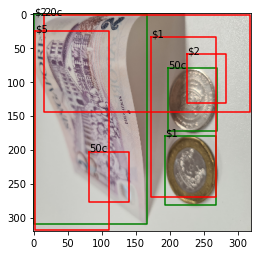

In [51]:
from PIL import Image

def display_predictions(img, gt_bbox, max_per_image=5):
    img = img.to(device)
    with torch.no_grad():
        cls_score, cls_pred, cls_prob, bbox_pred, rois = net(img, None, train_flag=False)
        boxes = rois[:, 1:5]
        n_anchors = int(bbox_pred.shape[0] / (NUM_OF_CLASS * 4))
        scores = cls_prob.view(n_anchors, -1)
        box_deltas = bbox_pred.view(n_anchors, -1)
        boxes = bbox_transform_inv(boxes, box_deltas)
        boxes = clip_boxes(boxes, [320,320])
        predictions = filter_predictions(scores.cpu(), boxes.cpu(), 0.3, 0.129)
        img = img.view(-1, 320, 320)
        predictions = {label: bboxes[:1] for label, bboxes in predictions.items()}
        predicted_boxes = []
        for label, bboxes in predictions.items():
            for bbox in bboxes:
                bbox_list = bbox.tolist()
                bbox_list.insert(4, label_index_dict[label])
                predicted_boxes.append(bbox_list)
        top_n_predicted_boxes = sorted(predicted_boxes, key=lambda x: x[4])[:max_per_image]
        display_img_bbox(img, gt_bbox[0], top_n_predicted_boxes)

net = torch.load('model')
device = torch.device('cuda')
net.to(device)
img, bbox = iter(test_dataloader).next()
display_predictions(img, bbox)